# Réseau de neurones: les bases en numpy


Le but de ce TP est de voir les bases des réseaux de neurones en numpy. Puis de voir comment en pratique on s'en sert avec la librairie Pytorch.

Ce TP sera **à rendre** (voir Discord).
Il y a n points dans ce TP, qui seront divisé pour obtenir une note sur 4.

Ce TP est à faire avec votre **groupe**. Rendez-le avec votre **groupe**.

Si vous avez des **questions**, n'hésitez pas à me les poser sur **Discord**

## Lecture des données, tokenization et BoW

Dans cette section vous devez lire les données (seulement les consensus).

Vous devez construire votre tokenizer (et de préférence le sauvegarder).

Vous devez transformer votre jeu de données (liste de tweets et labels) en liste de vecteurs BoW + liste d'indice des labels.

In [1]:
# Les imports sont préparé ici
# n'enlevez pas les % car il permettent le reload de modules ou l'affichage dans le notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import random
import pickle as pkl
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

**Tache 1** 1pt.

Importez/réécrivez le code permettant de lire vos données et les transformer en BoW.

A la fin de cette cellule, vous devrez avoir trois variables d'instanciées :
- X : la liste des vecteurs BoW de vos tweets
- Y_one_hot : la liste des indices des labels de vos tweets (Y_one_hot[i] doit contenir le label de X[i])
- Y_one_hot : la liste des labels sous forme one_hot (c'est similaire à un BoW, vous prenez un vecteur de zeros et mettez un 1 à l'indice du label)

In [2]:
def read_corpus(path, consensus=False):
    f = open(path, 'r', encoding='UTF-8')
    lines = f.readlines()
    f.close()
    corpus = []
    for l in lines:
        sl = l.split()
        if len(sl) == 0:
            continue
        if consensus:
            m = re.match(r"[(](.*),(.*),(consensus)[)]", sl[0])
            if m is not None:
                corpus.append([sl[1:], sl[0]])
        else:
            corpus.append([sl[1:], sl[0]])
    return corpus



class WordTokenizer:
    def __init__(self, bos='BOS', eos='EOS', unk='UNK', pad='PAD'):

        self.pad = pad
        self.unk = unk
        self.bos = bos
        self.eos = eos

        self.word2id = {pad: 0,
                        unk: 1,
                        bos: 2,
                        eos: 3}

        self.id2word = {0: pad,
                        1: unk,
                        2: bos,
                        3: eos}

    def add_to_voc(self, sent):
        """
        :param sentence: string
        :return: None
        """
        for w in sent:
            if w not in self.word2id.keys():
                self.word2id[w] = len(self.id2word.keys())
                self.id2word[self.word2id[w]] = w

    def str_to_ids(self, sentence):
        sent = sentence.split()
        ret = []
        for w in sent:
            if w not in self.word2id.keys():
                ret.append(self.word2id[self.unk])
            else:
                ret.append(self.word2id[w])

        return ret

    def words_to_ids(self, sent):
        ret = []
        for w in sent:
            if w not in self.word2id.keys():
                ret.append(self.word2id[self.unk])
            else:
                ret.append(self.word2id[w])

        return ret

    def ids_to_words(self, ids):
        words = []
        for i in ids:
            words.append(self.id2word[i])
        return words


class CharTokenizer:
    def __init__(self, bos='<B>', eos='<E>', unk='<U>', pad='<P>'):

        self.pad = pad
        self.unk = unk
        self.bos = bos
        self.eos = eos

        self.char2id = {pad: 0,
                        unk: 1,
                        bos: 2,
                        eos: 3}

        self.id2char = {0: pad,
                        1: unk,
                        2: bos,
                        3: eos}

    def add_to_voc(self, sentence):
        """
        adds vocabulary (chars) found in sentence to the dictionaries
        :param sentence: string
        :return: None
        """
        for w in sentence:
            if w not in self.char2id.keys():
                self.char2id[w] = len(self.id2char.keys())
                self.id2char[self.char2id[w]] = w

    def chars_to_ids(self, sentence):
        ret = []
        for c in sentence:
            if c not in self.char2id.keys():
                ret.append(self.char2id[self.unk])
            else:
                ret.append(self.char2id[c])

        return ret

    def ids_to_chars(self, ids):
        chars = ""
        for i in ids:
            chars += self.id2char[i]
        return chars


class TrigramTokenizer:
    def __init__(self, bos='<B>', eos='<E>', unk='<U>', pad='<P>'):

        self.pad = pad
        self.unk = unk
        self.bos = bos
        self.eos = eos

        self.char2id = {pad: 0,
                        unk: 1,
                        bos: 2,
                        eos: 3}

        self.id2char = {0: pad,
                        1: unk,
                        2: bos,
                        3: eos}

    def add_to_voc(self, sentence):
        """
        adds vocabulary (chars) found in sentence to the dictionaries
        :param sentence: string
        :return: None
        """
        for i in range(len(sentence)-3):
            if sentence[i:i+3] not in self.char2id.keys():
                self.char2id[sentence[i:i+3]] = len(self.id2char.keys())
                self.id2char[self.char2id[sentence[i:i+3]]] = sentence[i:i+3]

    def chars_to_ids(self, sentence):
        ret = []
        for i in range(len(sentence)-3):
            if sentence[i:i+3] not in self.char2id.keys():
                ret.append(self.char2id[self.unk])
            else:
                ret.append(self.char2id[sentence[i:i+3]])

        return ret

    def ids_to_chars(self, ids):
        chars = ""
        for i in ids:
            chars += self.id2char[i]
        return chars

def list_to_bow(sent, dic):
    "sent list of ids, dic: dictionary {word, index}"
    vec = np.zeros(len(dic), dtype=int)
    for i in sent:
        vec[i] = 1
    return vec


def list_to_bow_freq(sent, dic):
    vec = np.zeros(len(dic))
    for i in sent:
        vec[i] += 1
    for i in range(len(vec)):
        vec[i] = vec[i] / len(sent)
    return vec


def n_grams(sents, n):

    new_sents = []
    dic = {}

    for s in sents:
        ns = []
        for i in range(len(s)-(n-1)):
            t = ""
            for j in range(n):
                t += f"{s[i+j]} "
            t = t[:-1]
            ns.append(t)
            if t not in dic:
                dic[t] = len(dic.keys())

        new_sents.append(ns)
    return new_sents, dic

In [3]:
# mettez votre code ici

corpus = read_corpus("./train_label_final.txt", consensus=True)
tokenizer = WordTokenizer()

labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
Y_one_hot = [] # Pour les labels il faut des vecteurs en one_hot, par exemple pour irr : [0,0,0,1]
Y = []
for i in range(len(corpus)):
    lab = re.match(r"[(].*,(.*),.*[)]", corpus[i][1])
    ap = np.zeros(len(labels.keys()))
    ap[labels[lab[1].lower()]] = 1
    Y.append(labels[lab[1].lower()])
    Y_one_hot.append(ap)


tweets = [c[0] for c in corpus]
for t in tweets:
    tokenizer.add_to_voc(t)

    
tweets_ids = [tokenizer.words_to_ids(t) for t in tweets]


X = [list_to_bow(tw, tokenizer.word2id) for tw in tweets_ids]
X_freq = [list_to_bow_freq(tw, tokenizer.word2id) for tw in tweets_ids]


print(X[0]) # x sont les tweets transformés en vecteurs BoW
print(len(X[0]))
print(X_freq[0])
print(len(X_freq[0]))
print(Y_one_hot[0]) # y sont les labels transformés en indice

[0 0 0 ... 0 0 0]
11762
[0. 0. 0. ... 0. 0. 0.]
11762
[1. 0. 0. 0.]


## Création du modèle

Nous allons d'abord créer une couche linéaire.
Celle ci comprendra le terme de biais.

Rappel de la formule de la couche linéaire: 
$$
\mathbf{a} = \mathbf{W}\mathbf{x}+ \mathbf{b}
$$

Notons *n_in* et *n_out* respectivement les dimensions de $\mathbf{x}$ et $\mathbf{y}$. 

**Tache 2** 1pt.
- Coder la fonction d'initialisation suivante, l'initialisation est aléatoire Gaussien centrée en 0 avec un écart type 1 / sqrt(n_in). La fonction retourne W et b. 


## Algorithme d'apprentissage 

On a tout ce qu'il faut pour mettre en oeuvre l'apprentissage d'un modèle simple. Le modèle est simplement une couche neuronale de sortie, sans couche cachée. 

L'algorithme se déroule en 2 temps, tout d'abord la préparation: 
- initialisation du modèle
- préparation des données et des variables permettant de stocker l'historique d'apprentissage
- initialisation des paramètres de l'algorithme d'optimisation Adam
- définir le nombre d'époque comme une variable

Puis vient la boucle d'apprentissage qui pour chaque époque effectue pour chaque exemple d'apprentissage : 
- inférence du modèle sur l'exemple d'apprentissage 
- calcul de la contribution de l'exemple à la  fonction objectif, et également au taux d'erreur de classification
- Calcul du gradient de sortie
- Mise à jour du modèle

# Partie 2 :  PyTorch

Le but de cette section est de répliquer ce que vous avez fait à la main grâce à une librairie spécialisée.

Cette librairie est Pytorch.

Dans cette librairie vous retrouverez la gestion des poids sous forme de couches dans le sous-module nn.
La gestion du gradient est quasiment automatique.

Le jeu de données sera toujours les vecteurs BoW obtenus.

In [4]:
train_X = X[:1500]
train_Y = Y_one_hot[:1500]
train_Y_nhot = Y[:1500]

valid_X = X[1500:]
valid_Y = Y_one_hot[1500:]
valid_Y_nhot = Y[1500:]


In [5]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.metrics import f1_score

device = 'cuda' if T.cuda.is_available() else 'cpu'

c:\users\antonin\appdata\local\programs\python\python37\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


**Tache 11** 3 pt

Implémentez le même modèle que précédemment.

Utilisez les couches Linear et LogSoftmax (les probabilités sont souvent des logs probabilités).
Cherchez dans la documentation de torch.nn pour les couches.

In [6]:
class Model(nn.Module): # pour faire un modèle dans pytorch il faut instancier la classe nn.Module
    def __init__(self, in_dim, out_dim):
        super(Model, self).__init__()
        self.embeding = nn.Embedding(in_dim, out_dim)
        self.linear1 = nn.Linear(in_dim, out_dim) # Ici se trouve la couche Wx + b
        self.softmax = nn.LogSoftmax(dim=1) # Pour pytorch, la plupars des fonction fonctionne avec des logarithmes
        
        
    def forward(self, inputs):
        # Quelque soit le modèle, il vous faut une fonction forward
        # Pour calculer la sortie d'une couche : y = couche(x) avec x un tensor
        #embeds = self.embeding(inputs.to(T.int64))
        # print(inputs.shape)
        y = T.tanh(self.linear1(inputs))
        preds = self.softmax(y)
        return preds    

**Tache 12** 2pt

Complétez la boucle d'entraînement.

In [7]:
def collate(batch):
    transposed_data = list(zip(*batch))
    return T.stack(transposed_data[0], 0), T.stack(transposed_data[1], 0)

def train(train_X, train_Y, valid_X, valid_Y, epochs=100, batch_size=64, lr = 1e-3):
    model = Model(len(train_X[0]), 4).to(device)
    
    opti = T.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss() # Pour calculer la crossentropy, il faut calculer la NLLL après un logsofmax
    
    
    ## Transformation des données pour l'entraînement
    #trn_X = [T.tensor(x, dtype=T.long) for x in train_X]
    #trn_Y = [T.tensor(y, dtype=T.long) for y in train_Y]
    
    #vld_X = [T.tensor(x, dtype=T.long) for x in valid_X]
    #vld_Y = [T.tensor(y, dtype=T.long) for y in valid_Y]
    
    trn_X = T.tensor(train_X, dtype=T.float)
    trn_Y = T.tensor(train_Y, dtype=T.long)
    
    vld_X = T.tensor(valid_X, dtype=T.float)
    vld_Y = T.tensor(valid_Y, dtype=T.long)
    
    train_set = data.TensorDataset(trn_X, trn_Y)
    valid_set = data.TensorDataset(vld_X, vld_Y)
    
    
    ## Creation des loaders
    train_sampler = data.BatchSampler(data.RandomSampler(range(len(train_X))), batch_size, False)
    valid_sampler = data.BatchSampler(data.SequentialSampler(range(len(valid_X))), len(valid_X), False)
    
    train_loader = data.DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate) # TODO: ajouter shuffle=True ??
    valid_loader = data.DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=collate) # TODO: ajouter shuffle=True ??
    
    
    losses = []
    f1_valid = []
    
    for e in range(epochs):
        
        model.train() #passe votre modele en phase d'entrainement 
        
        for batch_ndx, (trn_x, trn_y) in enumerate(train_loader):
            opti.zero_grad()
            
            preds = model(trn_x.to(device))
            loss = criterion(preds, trn_y.to(device))
            losses.append(loss.item())
            loss.backward()
            opti.step()
            
        opti.zero_grad()
        model.eval()
        
        #with torch.no_grad() # pour gagner du temps en ne générant pas de graphe pour la validation
        for batch_ndx, (vld_x, vld_y) in enumerate(valid_loader):
            
            preds_val = model(vld_x.to(device))
            preds = T.argmax(preds_val, dim=1)
            f1_valid.append(f1_score(vld_y.to('cpu').numpy(), preds.to('cpu').numpy(), average='micro',
                            labels=[i for i in range(4)]))
        print(f"F1 {e}/{epochs}: {f1_valid[-1]}")
    
    return model, losses, f1_valid
        

In [8]:
model, losses, f1_valid = train(train_X, train_Y_nhot, valid_X, valid_Y_nhot, epochs=200, lr=1e-4)

c:\users\antonin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


F1 0/200: 0.39767054908485855
F1 1/200: 0.519134775374376
F1 2/200: 0.5690515806988353
F1 3/200: 0.5806988352745425
F1 4/200: 0.5823627287853578
F1 5/200: 0.5973377703826955
F1 6/200: 0.5990016638935108
F1 7/200: 0.5973377703826955
F1 8/200: 0.6023294509151415
F1 9/200: 0.6023294509151415
F1 10/200: 0.6006655574043261
F1 11/200: 0.6039933444259568
F1 12/200: 0.6056572379367721
F1 13/200: 0.610648918469218
F1 14/200: 0.610648918469218
F1 15/200: 0.6123128119800333
F1 16/200: 0.6123128119800333
F1 17/200: 0.6123128119800333
F1 18/200: 0.6123128119800333
F1 19/200: 0.6123128119800333
F1 20/200: 0.6139767054908486
F1 21/200: 0.6156405990016639
F1 22/200: 0.6156405990016639
F1 23/200: 0.6156405990016639
F1 24/200: 0.6156405990016639
F1 25/200: 0.6206322795341098
F1 26/200: 0.6206322795341098
F1 27/200: 0.6206322795341098
F1 28/200: 0.6206322795341098
F1 29/200: 0.6206322795341098
F1 30/200: 0.6206322795341098
F1 31/200: 0.6206322795341098
F1 32/200: 0.6206322795341098
F1 33/200: 0.620632279

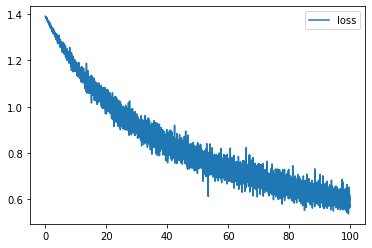

In [9]:
plt.plot([x/(len(losses)/100) for x in range(len(losses))],losses, label="loss")
plt.legend(loc='best')
plt.show()

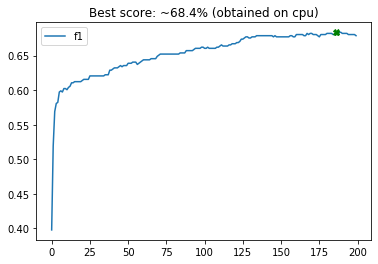

In [10]:
plt.plot(f1_valid, label='f1')
plt.legend(loc='best')

bestIndex = np.argmax(f1_valid)
bestNC, bestScore = np.arange(0, 200, 1)[bestIndex], f1_valid[bestIndex]
plt.plot(bestNC, f1_valid[bestIndex], marker='X', color='green')
plt.title("Best score: ~{0:.1%} (obtained on {1})".format(bestScore, device))

plt.show()

_Score du modèle fourni initialement : ~68%_

C'est super! Vous avez fini.